In [1]:
# Imports

import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

import os
from generator import Generator
from utils import conf_from_yaml, generator_from_conf, save_yaml

<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterHierarchyMatcher> already registered; second conversion method ignored.
/opt/anaconda3/envs/v3env-dyramo/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


seed: 2628796561
Starting generation...
<Best reward updated> 1 - time: 0.00, reward: 0.0000, node: Cc1ccccc1-c1nc(C[NH+]2CCN([C@@H](C)C(=O)N3CCCC3)CC2)cs1
<Best reward updated> 4 - time: 0.20, reward: 0.2662, node: Fc1cccc(CN2CC[C@@H]([NH+]3CCCC3)C2)c1
<Best reward updated> 5 - time: 0.21, reward: 0.3408, node: c1cc(N2CCCC2)cc(N2CC[NH2+]CC2)c1
<Best reward updated> 9 - time: 0.30, reward: 0.3539, node: O=c1c2ccccc2ncn1Cc1ccncn1
<Best reward updated> 18 - time: 0.47, reward: 0.4047, node: c1coc([C@@H]2CCCC[C@H]2[NH2+]C2CCOCC2)n1
<Best reward updated> 47 - time: 0.99, reward: 0.4156, node: O=S(=O)(c1ccccc1)N1CCn2c(nnc2-c2ccncc2)C1
<Best reward updated> 91 - time: 1.76, reward: 0.4391, node: C[C@H]1OCC[C@H]1[C@@H](N)c1ccc(F)cc1
100 - time: 1.91, average over 100: 0.2185
200 - time: 3.68, average over 100: 0.2234
<Best reward updated> 245 - time: 4.44, reward: 0.4731, node: NS(=O)(=O)c1ccc(-n2ccc3ncncc3c2=O)cc1
300 - time: 5.36, average over 100: 0.2494
Generation interrupted by user (Key

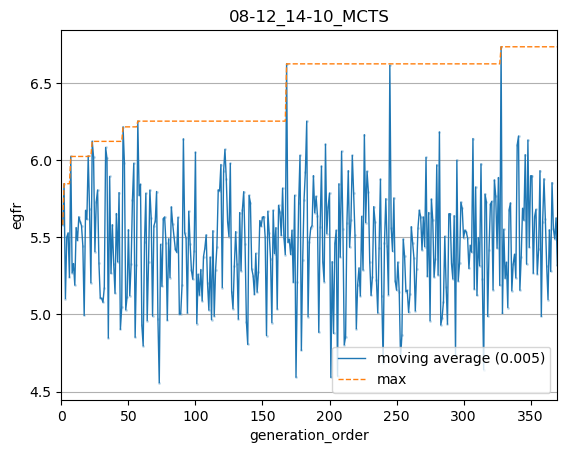

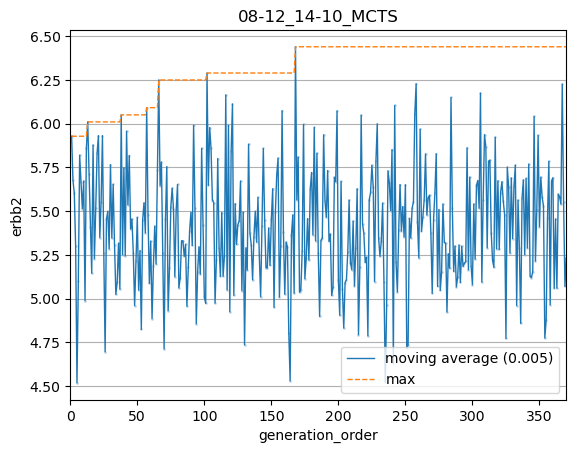

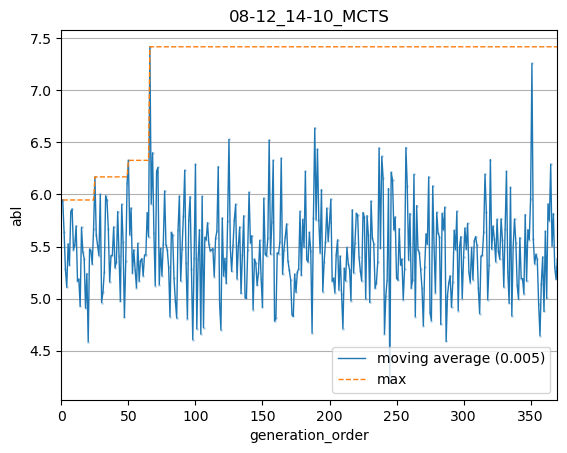

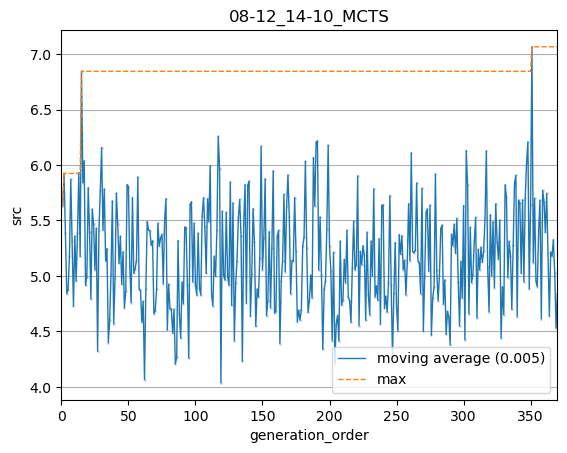

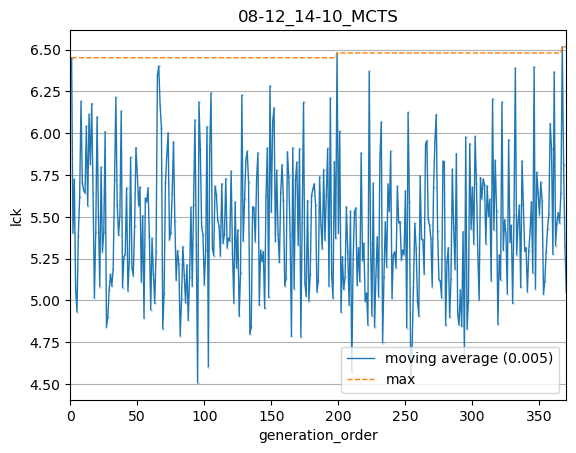

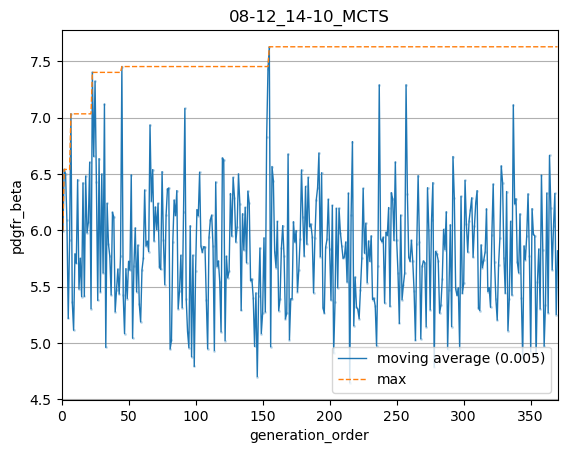

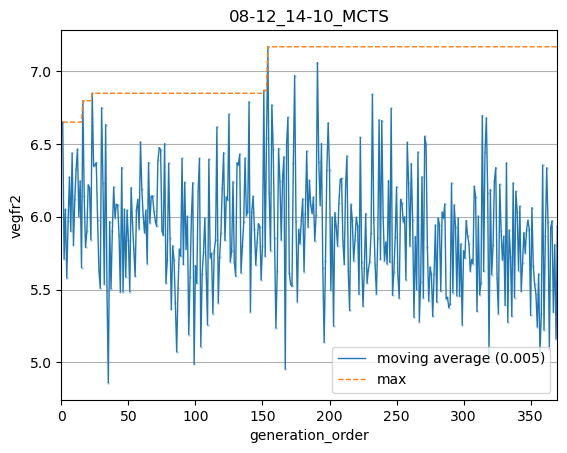

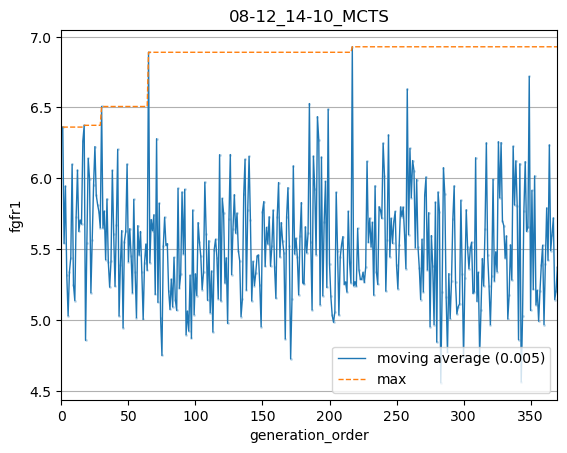

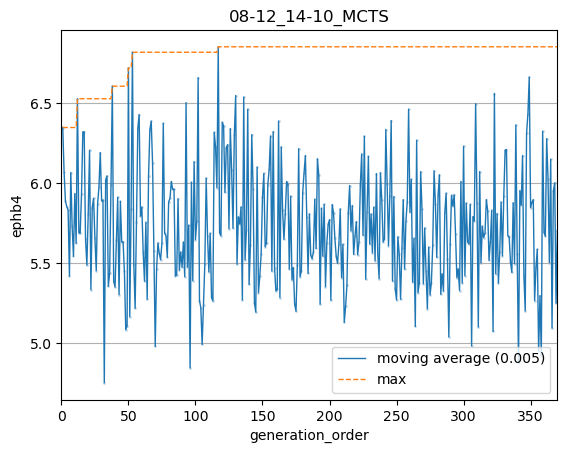

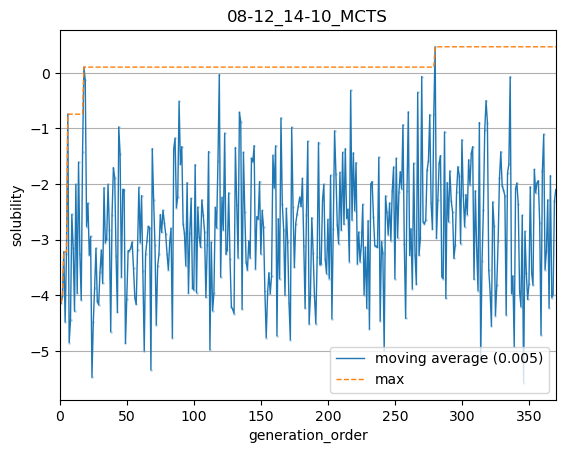

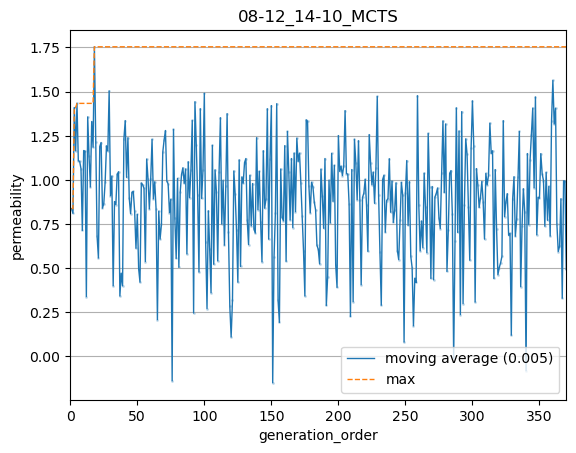

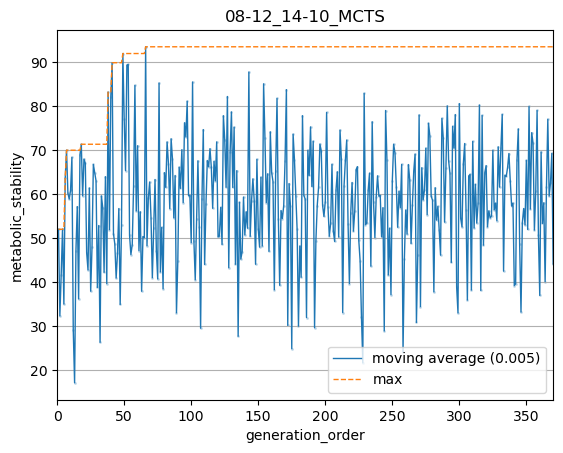

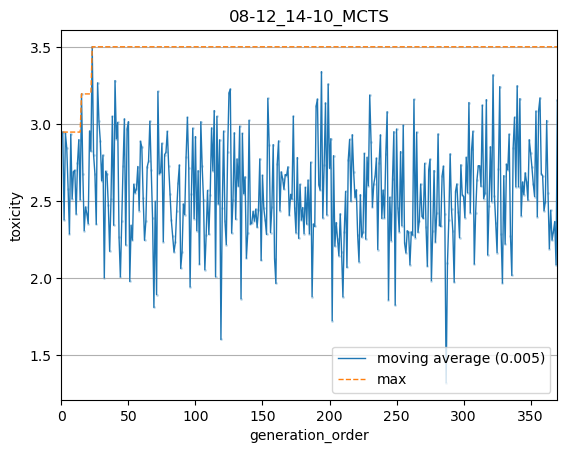

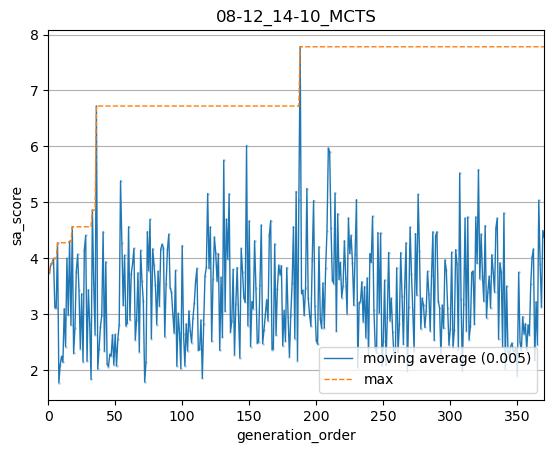

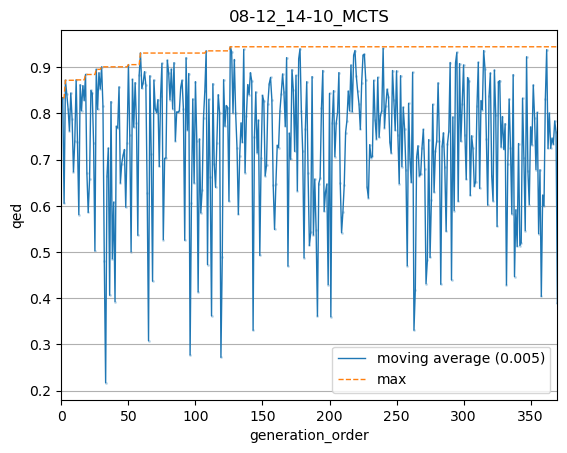

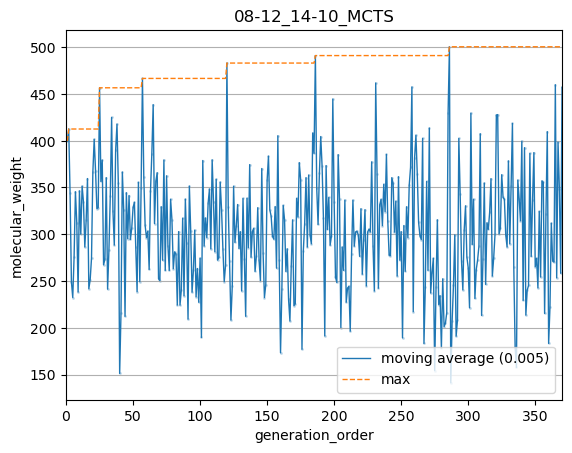

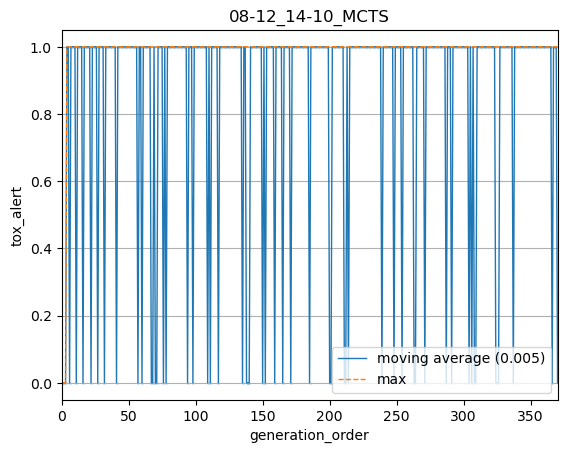

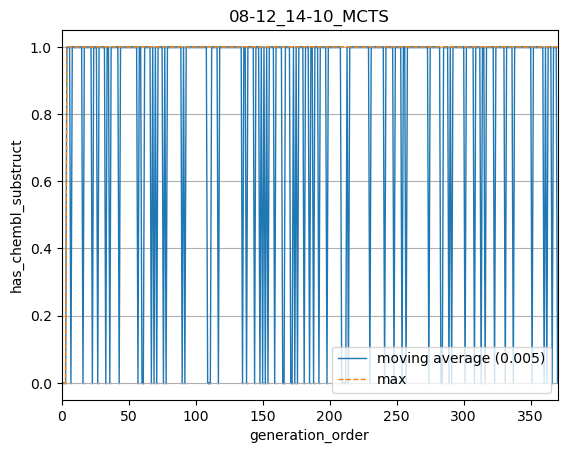

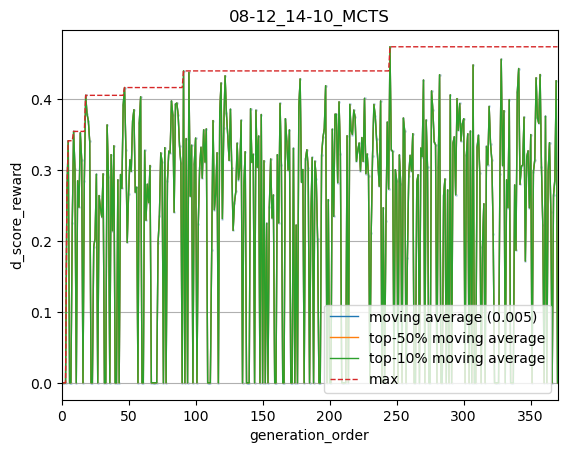

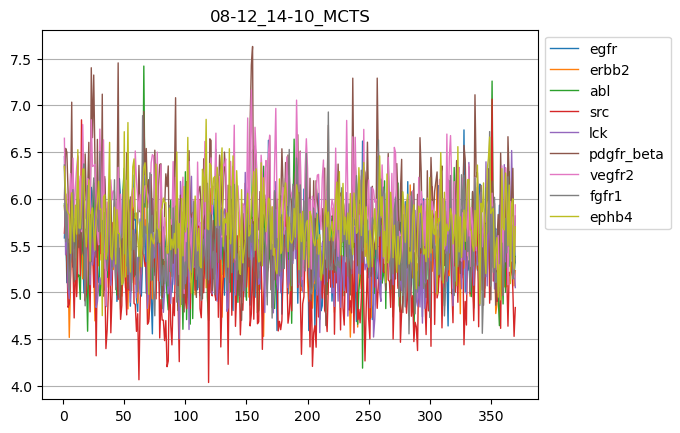

Number of generated nodes: 370
Valid rate: 0.8665105386416861
Unique rate: 1.0
Node per sec: 55.76954857208385
Best reward: 0.47305005225514385
Average reward: 0.23037528162945578
Top 10 AUC: 0.36427818272398527


In [ ]:
# Start generation

yaml_path = "config/mcts/dyramo.yaml" # Specify the yaml path

conf = conf_from_yaml(yaml_path)
generator = generator_from_conf(conf)
generator.generate(time_limit=conf.get("time_limit"), max_generations=conf.get("max_generations"))

generator.plot(**conf.get("plot_args", {}))
generator.analyze()

In [ ]:
# Chain

n_top_keys_to_pass=conf.get("n_keys_to_pass", 3)
yaml_path = conf.get("next_yaml_path", "config/mcts/example_chain_2.yaml")

conf = conf_from_yaml(yaml_path)
generator = generator_from_conf(conf, predecessor=generator, n_top_keys_to_pass=n_top_keys_to_pass)

generator.generate(time_limit=conf.get("time_limit"), max_generations=conf.get("max_generations"))

In [ ]:
# Save generator

save_dir = os.path.join(generator.output_dir(), "save")
os.makedirs(save_dir, exist_ok=True)
save_yaml(conf, save_dir, overwrite=True)
generator.save(os.path.join(save_dir, "save.gtr"))

In [ ]:
# Load generator

load_dir = "sandbox/generation_result/~~~/save" # Specify the save dir
generator = Generator.load_dir(load_dir)

In [ ]:
# Continue generation

generator.generate(max_generations=500, time_limit=60)